In [1]:
pwd

'/lustre/projects/project-broaddus/fisheye'

In [2]:
!module list

No Modulefiles Currently Loaded.


In [ ]:
status

In [3]:
from math import ceil

def set_cell_width(percent=100):
    assert 10 < percent <= 100
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:%d%% !important; }</style>" % percent))

def perm(arr,p1,p2):
  "permutation mapping p1 to p2 for use in numpy.transpose. elems must be unique."
  assert len(p1)==len(p2)
  perm = list(range(len(p1)))
  for i,p in enumerate(p2):
    perm[i] = p1.index(p)
  return arr.transpose(perm)

def imshow(img, fs=(20,20), cb=True, **kwargs):
    plt.figure(figsize=fs, **kwargs)
    ax = plt.imshow(img, **kwargs)
    if cb:
        plt.colorbar()
    return ax

def timewindow(lst, t, l):
    "window of fixed length l, into list lst. try to center around t."
    if t < l//2: t=l//2
    if t >= len(lst) - l//2: t=len(lst) - ceil(l/2)
    return lst[t-l//2:t+ceil(l/2)]

In [4]:
set_cell_width()

In [5]:
import numpy as np
import sys
import os, shutil

from tifffile import imread, imsave
from scipy.ndimage import zoom, label, distance_transform_edt, rotate
from scipy.signal import gaussian
from scipy.ndimage.morphology import binary_dilation
import matplotlib.pyplot as plt

from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard, ReduceLROnPlateau

import unet
import warping
import lib as ll

from skimage.morphology import watershed
from scipy.ndimage import label

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/tifffile/tifffile.py:7685: UserWarning: No module named 'tifffile._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn('%s%s' % (e, warn))
/sw/apps/python3/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/sw/apps/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/sw/apps/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/sw/apps/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/sw/apps/python3/3.6.5/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/sw/apps/python3/3.6.5/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcublas.so.9.0: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [16]:
name = "training/t009/"


# img6orig  = imread('data/img006_borderlabels.tif')
# img6orig2 = imread('data/img006+lab.tif')
# inds, traindata = ll.fixlabels(img6)

In [17]:
img6 = imread('data/img006.tif')
img6lut = imread('data/labels_lut.tif')
img6_w_labs = np.concatenate([img6lut[:,:,[0]], img6], axis=2)
inds, traindata = ll.fixlabels(img6_w_labs)

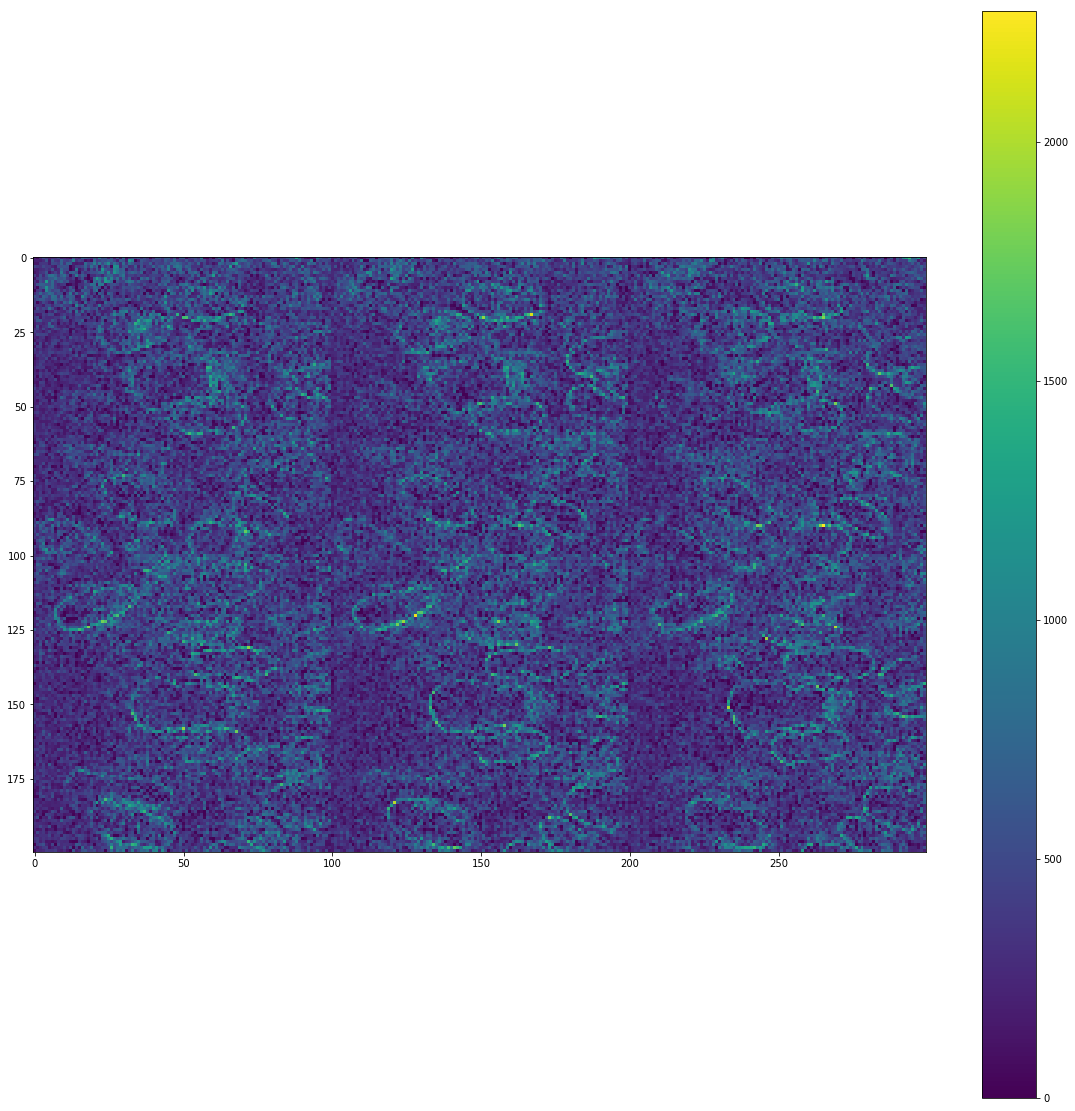

In [20]:
## plot grid of img6 subset
x = img6[[0,1]]
x = x[:,[0,1,2]]
x = x[:,:,[0],::4,::4]
x = perm(x,"tzcyx","tyzxc")
a,b,c,d,e = x.shape
x = x.reshape((a*b,c*d*e))
imshow(x)

In [18]:
traindata.shape

(31, 3, 400, 400)

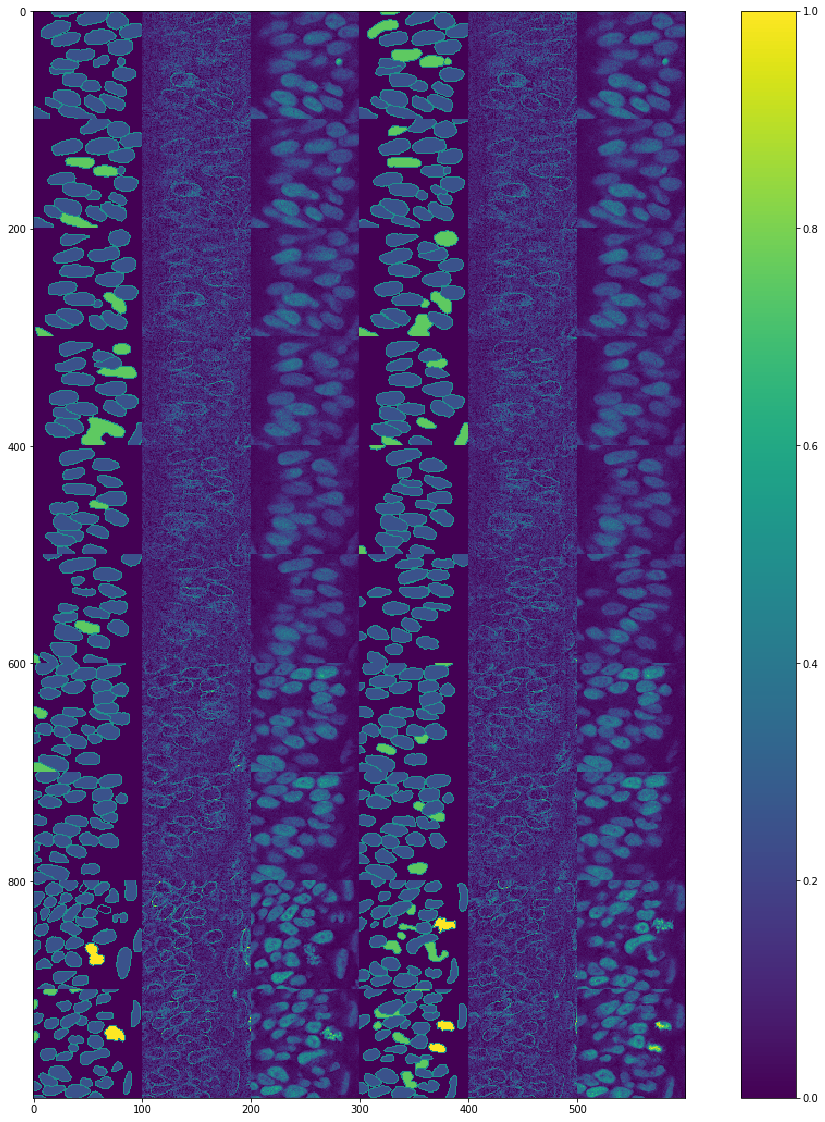

In [58]:
## plot grid of traindata subset
x = traindata[-20:,:,::4,::4]
a,b,c,d = x.shape
x = x.reshape((10,2,b,c,d))
x = perm(x,'12cyx','1y2cx')
a,b,c,d,e = x.shape
x = x/x.max((0,1,2,4), keepdims=True)
x = x.reshape((a*b, c*d*e))
imshow(x)

In [251]:
## arrange into xs and ys
xs_xy = traindata[:,[1,2]].copy()
ys_xy = traindata[:,0].copy()

xs = perm(xs_xy,'zcyx','zyxc')
ys = ys_xy #.transpose(perm('zcyx','zyxc'))

# ys[ys==3] = 1
# ys[ys==4] = 1

In [252]:
## Augmentation

xs1 = np.flip(xs, axis=1)
xs2 = np.flip(xs, axis=2)
xs12 = np.flip(np.flip(xs, axis=1), axis=2)
xs = np.concatenate((xs,xs1,xs2,xs12), axis=0)

ys1 = np.flip(ys, axis=1)
ys2 = np.flip(ys, axis=2)
ys12 = np.flip(np.flip(ys, axis=1), axis=2)
ys = np.concatenate((ys,ys1,ys2,ys12), axis=0)

In [253]:
n_classes = len(np.unique(ys))
# classweights = (1-counts/counts.sum())/(len(counts)-1)
classweights = [1/n_classes,]*n_classes

# distimg /= distimg.mean()
ys = np_utils.to_categorical(ys).reshape(ys.shape + (-1,))

In [254]:
ys.shape

(124, 400, 400, 5)

In [255]:
# split 400x400 into 100x100 patches
nz,ny,nx,nc = xs.shape
ny4,nx4 = ny//4, nx//4
xs = xs.reshape((nz,4,ny4,4,nx4,nc))
xs = perm(xs,"z1y2xc","z12yxc")
xs = xs.reshape((-1,ny4,nx4,nc))
nz,ny,nx,nc = ys.shape
ys = ys.reshape((nz,4,ny4,4,nx4,nc))
ys = perm(ys,"z1y2xc","z12yxc")
ys = ys.reshape((-1,ny4,nx4,nc))

In [256]:
## Turn off the irrelevant class
mask = ys[...,3]==1
ys[mask] = 0

In [257]:
ys.shape

(1984, 100, 100, 5)

In [259]:
## reweight border pixels
a,b,c,d = ys.shape
distimg = np.zeros((a,b,c), dtype=np.float16)
mask = ys[...,2]==1
distimg[~mask] = 1
distimg = np.array([distance_transform_edt(d) for d in distimg])
distimg = np.exp(-distimg/10)
distimg = distimg/distimg.mean((1,2), keepdims=True)

ys = ys*distimg[...,np.newaxis]

In [261]:
ys.max((0,1,2))

array([57.70774908, 18.50298937, 21.79001784,  0.        ,  4.88813263])

In [207]:
xsys = np.concatenate([xs,ys], axis=-1)

In [208]:
xsys.shape

(496, 100, 100, 7)

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


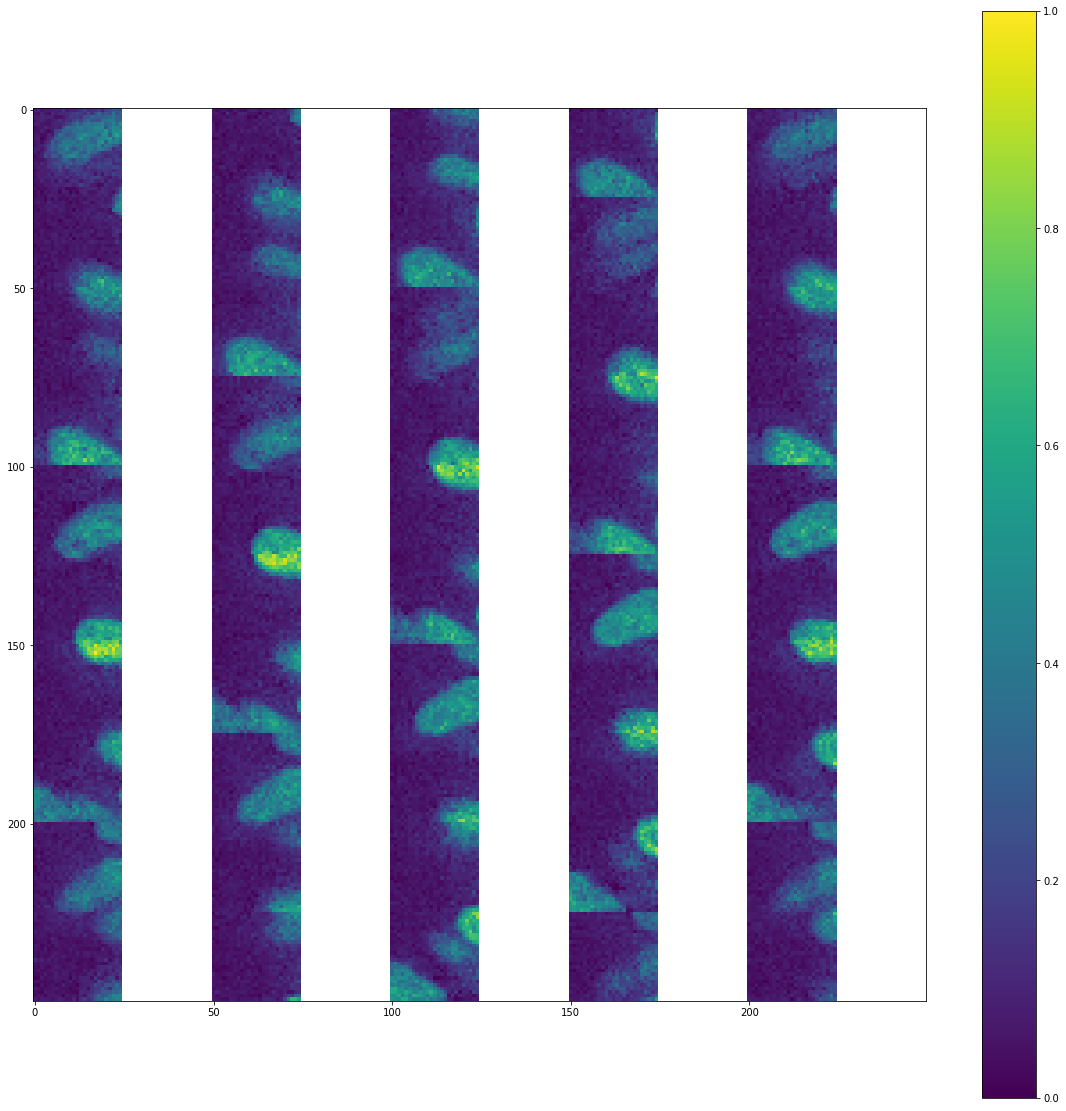

In [212]:
## make sure training data is still correct
x = xsys[:4*50][::4]
x = x[:,::4,::4,[1,6]]
a,b,c,d = x.shape
x = x.reshape((10,5,b,c,d))
x = perm(x,'12yxc','1y2cx')
a,b,c,d,e = x.shape
x = x/x.max((0,1,2,4), keepdims=True)
x = x.reshape((a*b,c*d*e))
imshow(x)

In [262]:
# normalize
xs = xs/xs.mean((1,2), keepdims=True)

# shuffle
inds = np.arange(xs.shape[0])
np.random.shuffle(inds)
invers = np.argsort(np.arange(inds.shape[0])[inds])
xs = xs[inds]
ys = ys[inds]

# train test split
split = 7
n_vali = xs.shape[0]//split
xs_train = xs[:-n_vali]
ys_train = ys[:-n_vali]
xs_vali  = xs[-n_vali:]
ys_vali  = ys[-n_vali:]

In [263]:
ys.shape

(1984, 100, 100, 5)

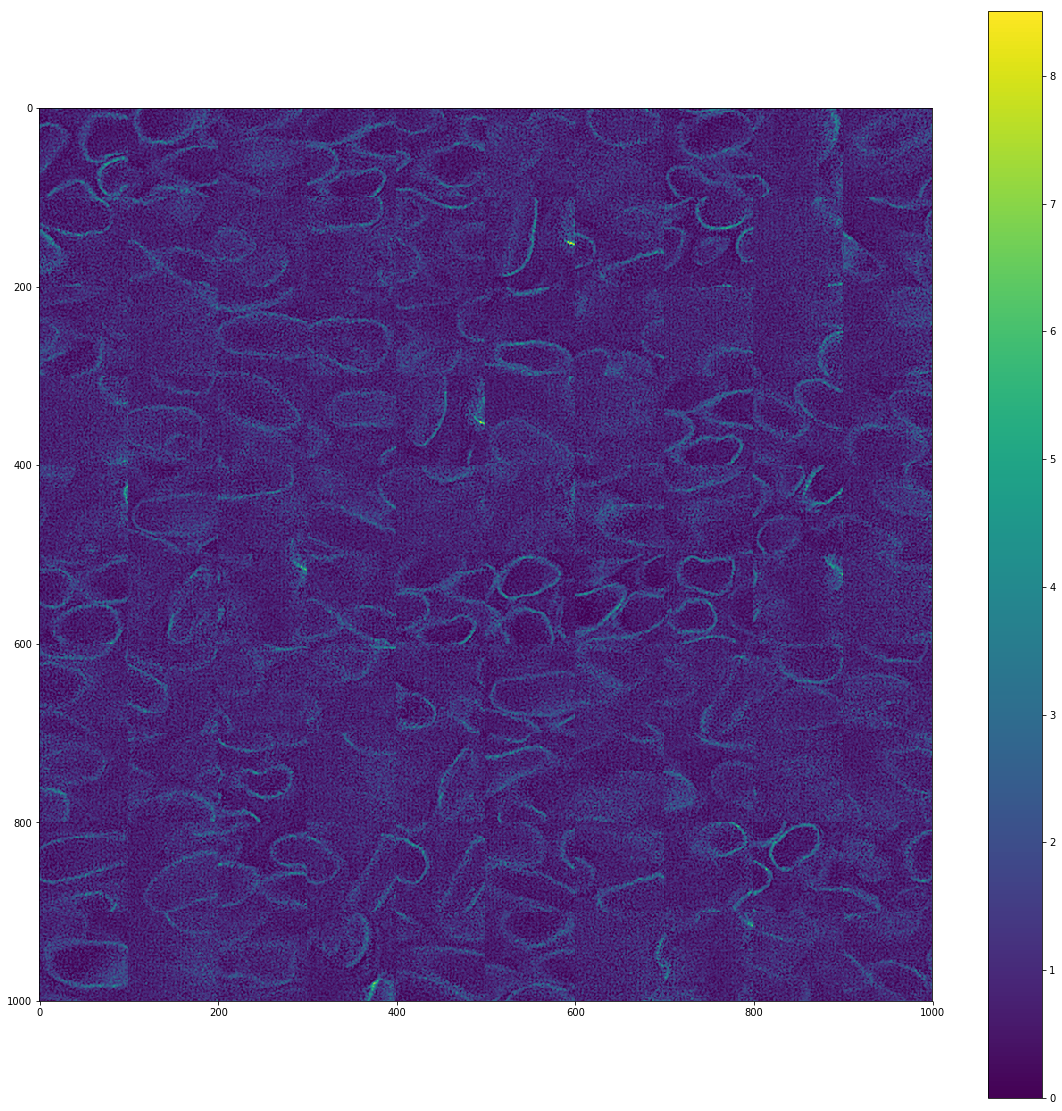

In [77]:
x = xs[:400:4]
a,b,c,d = x.shape
x = x.reshape((10,10,b,c,d))
x = perm(x,'12yzc','1y2zc')
a,b,c,d,e = x.shape
x = x.reshape((a*b,c*d,e))
imshow(x[...,0])

In [264]:
net = unet.get_unet_n_pool(n_pool=2,
                            inputchan=2,
                            n_classes=n_classes,
                            n_convolutions_first_layer=32,
                            dropout_fraction=0.2)

In [265]:
optim = Adam(lr=1e-4)
loss = unet.my_categorical_crossentropy(weights=classweights, itd=4)
net.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=name + "w001aug.h5", verbose=0, save_best_only=True, save_weights_only=True)
earlystopper = EarlyStopping(patience=30, verbose=0)
reduce_lr    = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
callbacks = [checkpointer, earlystopper, reduce_lr]

history = net.fit(x=xs_train,
                  y=ys_train,
                  batch_size=3,
                  epochs=60,
                  verbose=1,
                  callbacks=callbacks,
                  validation_data=(xs_vali, ys_vali))

net.save_weights(name + 'w002aug.h5')

Train on 1701 samples, validate on 283 samples
Epoch 1/60
1701/1701 [==============================] - 16s 9ms/step - loss: 0.1622 - acc: 0.6865 - val_loss: 0.1270 - val_acc: 0.7808
Epoch 2/60
1701/1701 [==============================] - 9s 5ms/step - loss: 0.1169 - acc: 0.7852 - val_loss: 0.1227 - val_acc: 0.7714
Epoch 3/60
1701/1701 [==============================] - 9s 5ms/step - loss: 0.1065 - acc: 0.8018 - val_loss: 0.1169 - val_acc: 0.7694
Epoch 4/60
1701/1701 [==============================] - 9s 5ms/step - loss: 0.1014 - acc: 0.8095 - val_loss: 0.1084 - val_acc: 0.7948
Epoch 5/60
1701/1701 [==============================] - 9s 5ms/step - loss: 0.0979 - acc: 0.8155 - val_loss: 0.1075 - val_acc: 0.8054
Epoch 6/60
1701/1701 [==============================] - 9s 5ms/step - loss: 0.0960 - acc: 0.8192 - val_loss: 0.1063 - val_acc: 0.8015
Epoch 7/60
1701/1701 [==============================] - 9s 5ms/step - loss: 0.0947 - acc: 0.8216 - val_loss: 0.0978 - val_acc: 0.8159
Epoch 8/60
170

1701/1701 [==============================] - 9s 5ms/step - loss: 0.0691 - acc: 0.8622 - val_loss: 0.0805 - val_acc: 0.8484


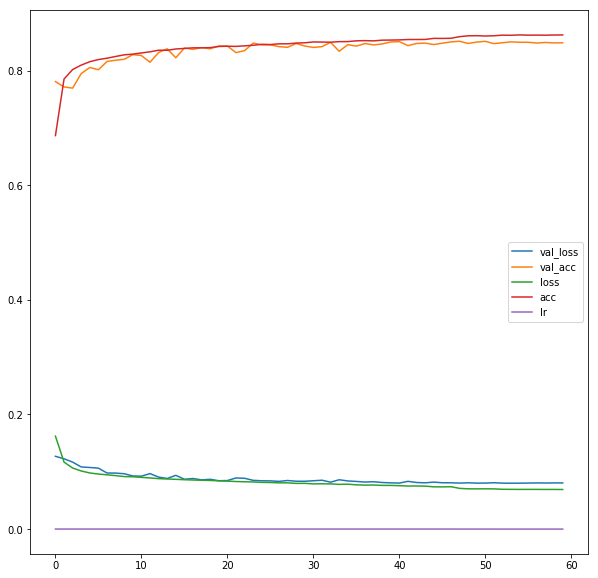

In [266]:
hh = history.history
plt.figure(figsize=(10,10))
for k in hh.keys():
    plt.plot(hh[k], label=k)
plt.legend()

In [267]:
img6.shape

(11, 71, 2, 400, 400)

In [268]:
%%time
x = perm(img6,"tzcyx","tzyxc")
a,b,c,d,e = x.shape
x = x.reshape((a*b,c,d,e))
x = x/x.mean((1,2), keepdims=True)
x.shape
img6pred = net.predict(x)
img6pred = img6pred.reshape((a,b,c,d,n_classes))

CPU times: user 3.44 s, sys: 4.06 s, total: 7.5 s
Wall time: 15 s


In [228]:
np.save(name + 'img6pred_5class_aug', img6pred)

In [269]:
img6pred.shape

(11, 71, 400, 400, 5)

### Now let's try to find divisions...

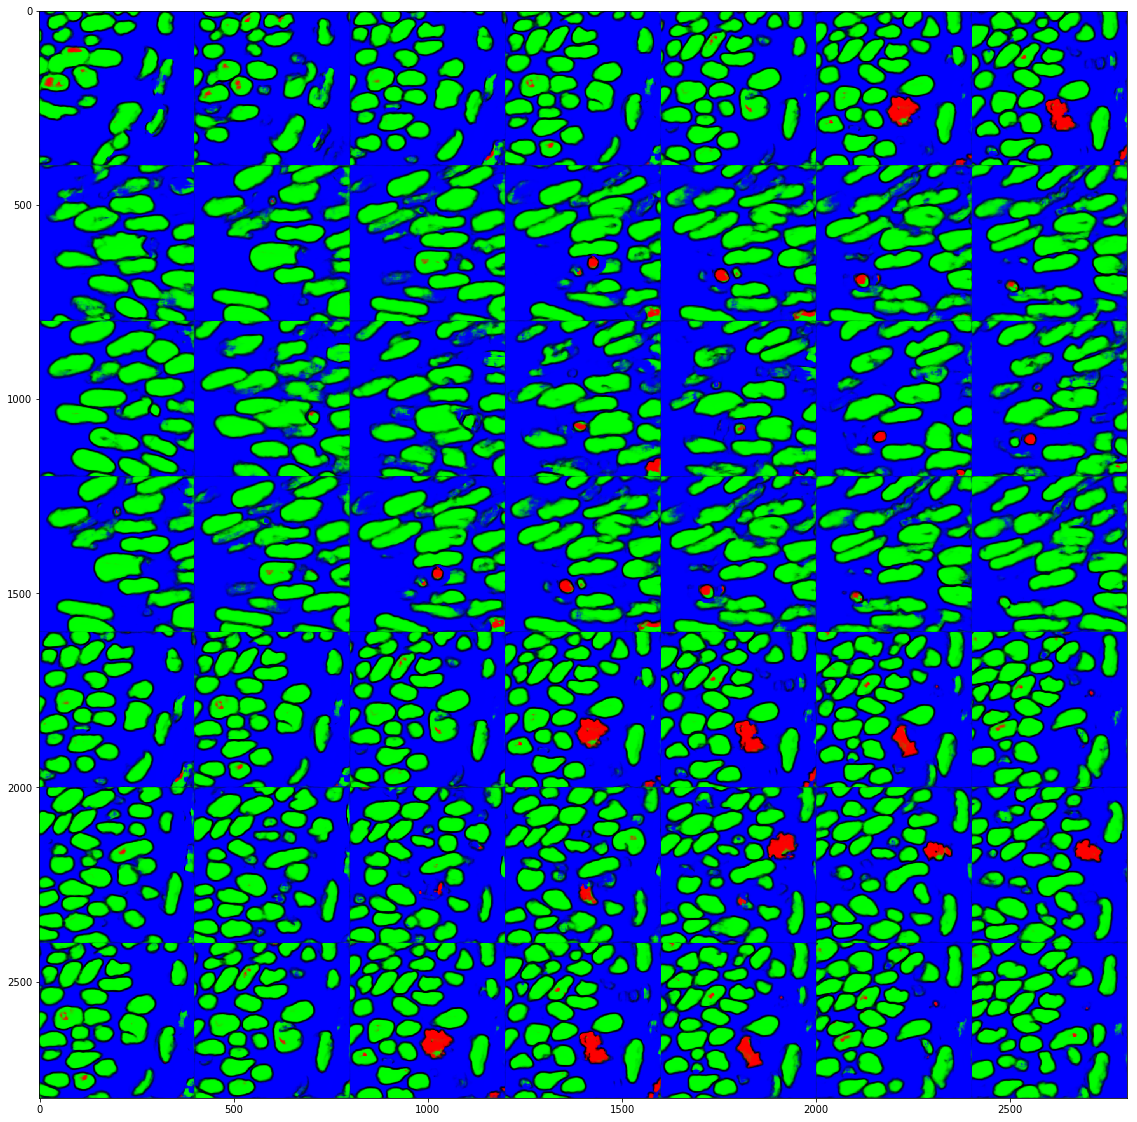

In [470]:
x = img6pred[:,:,:,:]
a,b,c,d,e = x.shape
x = x.reshape((a,b,c,d,e))
div = x[:,::6,...,4].sum((2,3))

dc = np.sort(div.flat)[-20]
tz = np.argwhere(div > dc)[:7]

lst = list(range(x.shape[0]))
x2 = x[:,::6]
x2 = np.array([x2[timewindow(lst, n[0], 7), n[1]] for n in tz])
a,b,c,d,e = x2.shape
x2.shape
x2 = perm(x2,'12yxc','1y2xc')
a,b,c,d,e = x2.shape
x2 = x2.reshape((a*b,c*d,e))
np.save('qsave.png',x2)
# imshow(x2[...,[4,1,0]], cb=False)

In [424]:
ran = range(11)
l = 5
t = 1
listaround(list(range(11)), 7, 5)

[5, 6, 7, 8, 9]

In [288]:
x2 = x2.reshape((4,3,400,400,5))
x2 = perm(x2,'12yxc','1y2xc')
x2 = x2.reshape((4*400,3*400,5))
imshow(x2[...,[4,1,0]])

0.99999964

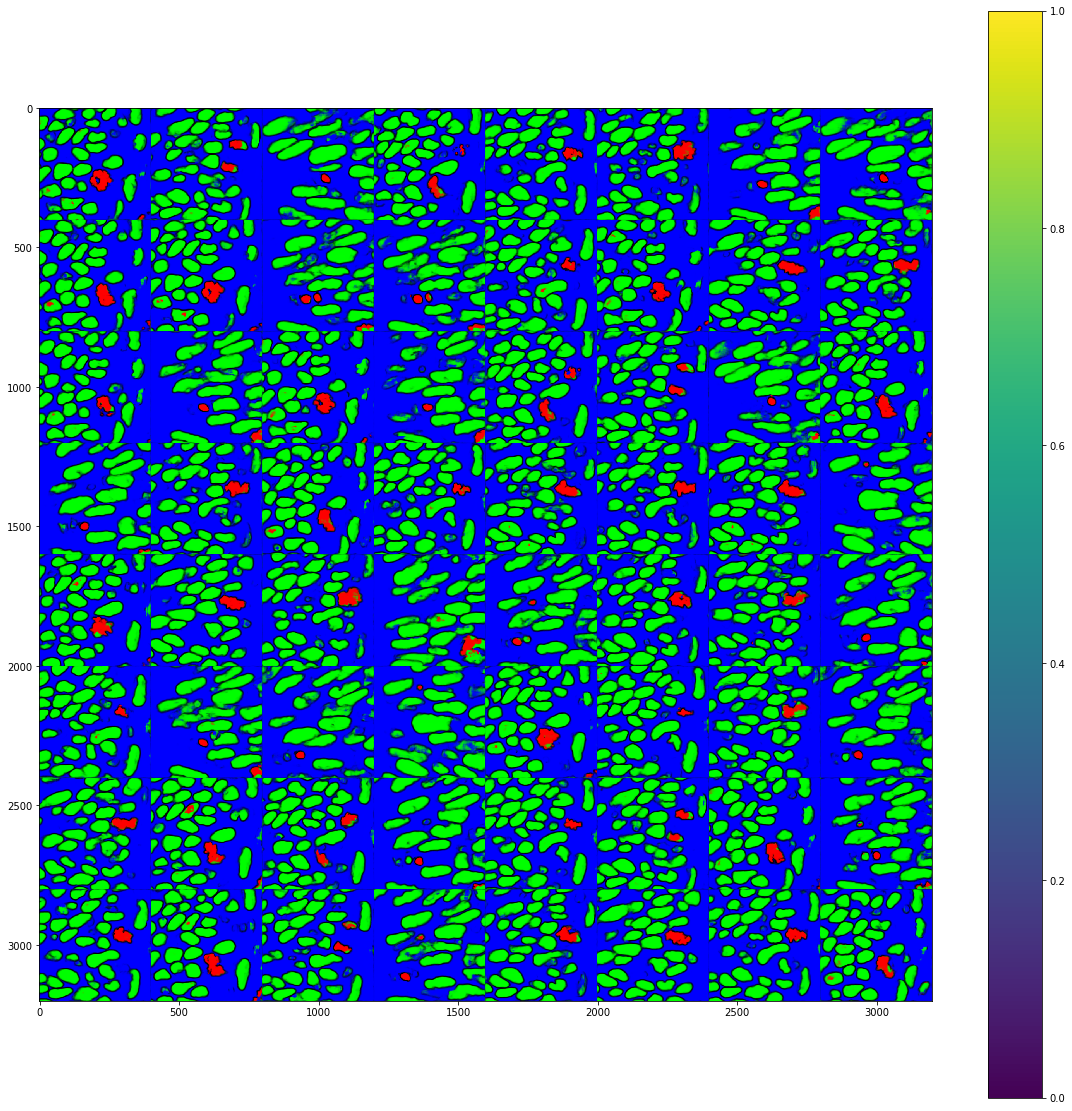

In [271]:
inds = np.argsort(div)[::-1]
x = x[inds][:64]
x = x.reshape((8,8,c,d,e))
x = perm(x,'12yxc','1y2xc')
a,b,c,d,e = x.shape
x = x.reshape((a*b,c*d,e))
imshow(x[...,[4,1,0]], cb=False)

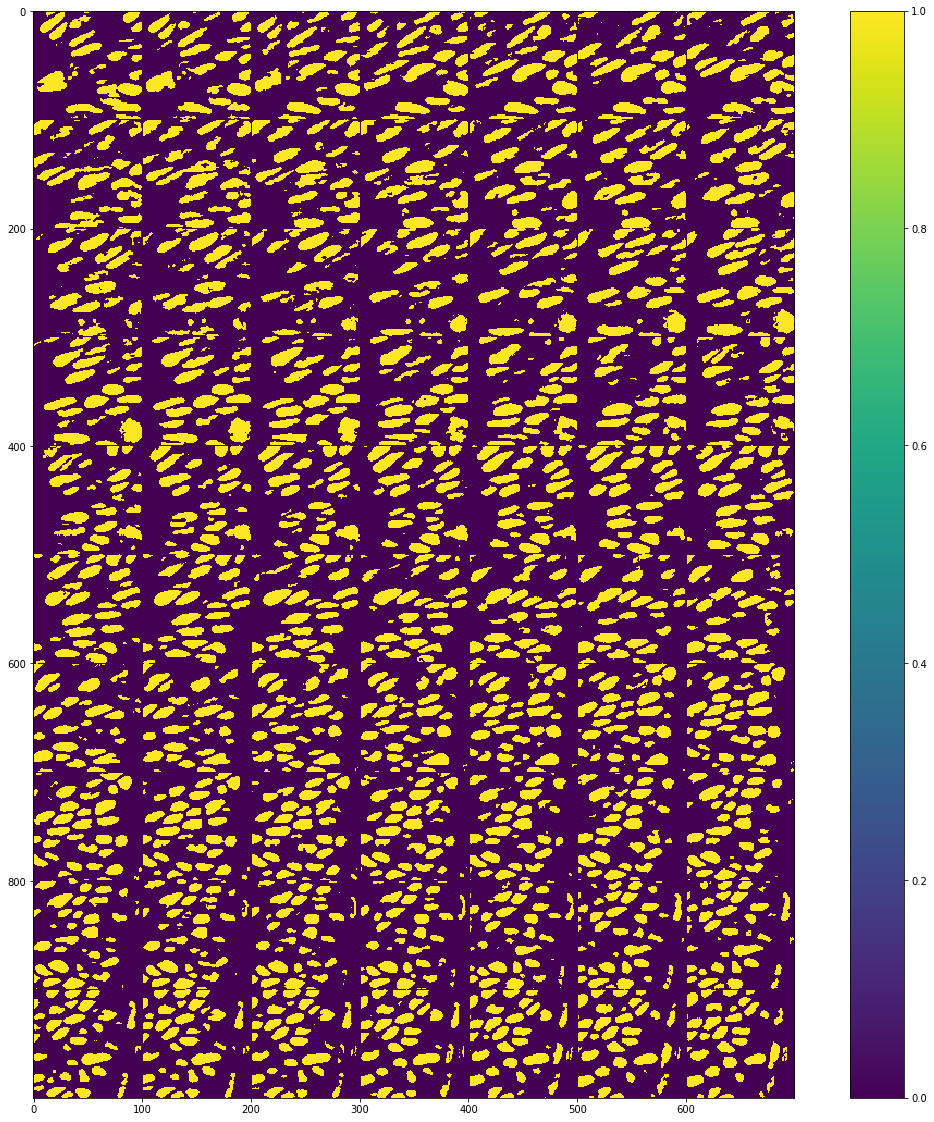

In [106]:
imshow((x[...,1]>0.9).astype(np.uint8))

In [116]:
res = watershed(1-x[...,1],label(x[...,1]>0.9)[0], mask = x[...,1]>0.5)

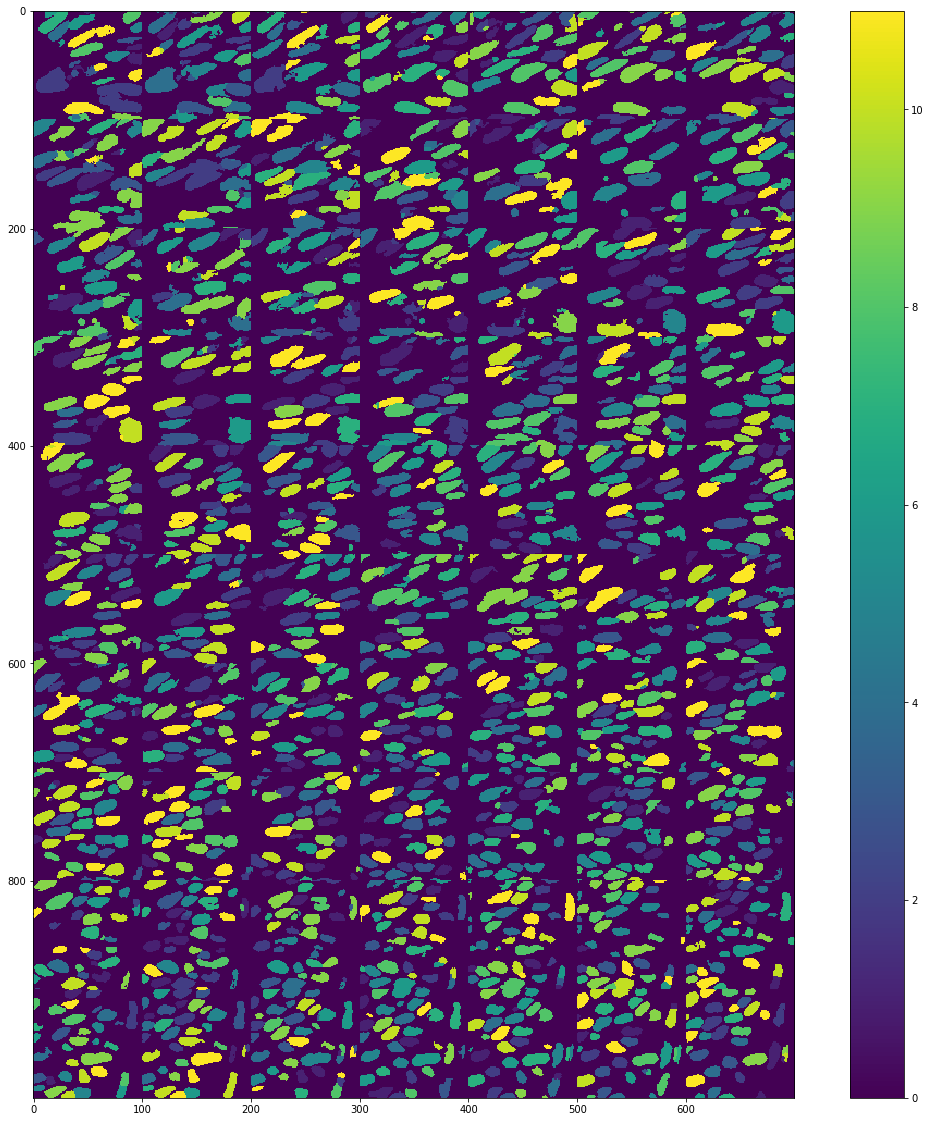

In [118]:
imshow(res%12)

In [42]:
## Note that in categorical crossentropy there is an asymmetry between FP and FN
## putting a 1 for a class that should be zero gives 0
## but putting a 0 for a class that should be a 1 gives -np.log(eps) which can be very large
## it is only because prob sums to 1 across classes that this doesn't cause a problem

np.log(1e-7)

-16.11809565095832

/sw/apps/python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/sw/apps/python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


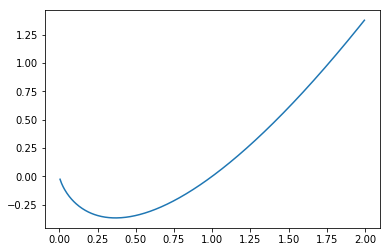

In [40]:
x = np.arange(400)/200
y = x*np.log(x)
plt.plot(x,y)

In [202]:
!du -hs training/t009/img6pred.npy

1.4G	training/t009/img6pred.npy
